<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/14_rl/01_Deep_Q_Network_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 目的
Deep Q-networkの仕組みを理解し，ゲームタスクを用いて強化学習をおこなう．\
学習後のエージェントの可視化を行い，学習がうまくできているか確認を行う．

# Deep Q-Network (DQN)
Deep Q-Network (DQN)は，GoogleのDeepmindが2016年に発表した手法で，Q学習におけるQテーブルを用いた行動価値の導出を，DCNNを用いた近似関数で代用するのが主な手法の内容である．

Q学習では，全ての状態と行動の組み合わせについて，行動価値をQテーブルに記録している．
そのため，状態数と行動数の組み合わせが膨大な環境に対して，膨大なメモリが必要となる問題を抱えていました．\
この問題に対して，DQNはQテーブルそのものをDCNNで代用することにより，上記問題を解決し，Atari2600のゲーム環境で人間を超えるスコアの獲得に成功している．
また，DQNにはその他にも強化学習における学習の安定性獲得のために，Experience replay，Target Q-Network，Reward clippingなどの工夫がなされている．

DQNのように，行動価値関数（Q値）を用いて行動を決定し，最適行動価値関数になるように更新を行っていく手法は，価値ベースの手法と呼ばれている．
派生手法には，DDQN，Ape-X，R2D2などの手法がある．

<img src="http://drive.google.com/uc?export=view&id=1J7YPwb1iMd4eKo3YKLc7Rk4XG-vT7hoz" width = 50%>


## 準備

### Google Colaboratoryの設定確認・変更
本チュートリアルではPyTorchを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**


### モジュールの追加インストール
下記のプログラムを実行して，実験結果の表示に必要な追加ライブラリやモジュールをインストールする．

In [1]:
!apt-get -qq -y install libcusparse9.1 libnvrtc9.1 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.9.1 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null

!pip -q install gym[atari,accept-rom-license]==0.23.1
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

     |████████████████████████████████| 626 kB 8.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.6 MB 34.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


## モジュールのインポート
はじめに必要なモジュールをインポートする．

今回はPyTorchに加えて，Pongを実行するためのシミュレータであるOpenAI Gym（gym）をインポートする．

In [2]:
import numpy as np
import gym
import gym.spaces

import time
import datetime
import math
import random
import cv2
import matplotlib
import matplotlib.pyplot as plt
import collections
from itertools import count
from PIL import Image
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# GPUの確認
use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

Use CUDA: True


## シード値の固定

In [3]:
seed = 123
# Python random
random.seed(seed)
# Numpy
np.random.seed(seed)
# Pytorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

## OpenAI GymによるPong環境の定義
 [OpenAI Gym](https://github.com/openai/gym) は，様々な種類の環境を提供しているモジュールです．
 
今回は，gymで利用可能なAtari2600のゲームであるPongを使用します．
まず，gym.make関数で実行したい環境を指定します．（今回はPong）
その後，reset関数を実行することで，環境を初期化します．
 
Pongは，パドルを操作してボールが自分の陣地に入らないように打ち返すゲームです．（いわゆる，スカッシュゲーム）\
Pongにおいて，現在の状態を確認するためにゲームの画面情報が与えられており，`observation_space`という変数で確認することができます．
また，`action_space`という変数で，エージェントが選択可能な行動の数を確認することができます．\
Pongの行動数は6で，内訳は以下の通りです．

- NOOP（操作なし）
- FIRE
- RIGHT
- LEFT
-	RIGHTFIRE
- LEFTFIRE

ただし，Pongでの動作はパドルを上下どちらかに移動させるのみのため，
FIREはNOOP，RIGHTFIREはRIGHT，LEFTFIREはLEFTと同じ動作となります．
そのため，行動の種類としては，パドルを上下どちらかに移動させる行動の2つとなっています．

Pongのゲーム概要は，相手の陣地にボールを入れることで得点を獲得し，ボールを自分の陣地に入れられることで得点を取られます．
どちらかのプレイヤーが21点取った時点でゲーム終了となります．




In [4]:
# 環境の指定
env = gym.make('ALE/Pong-v5', frameskip=1, repeat_action_probability=0.0, full_action_space=False)

# 環境の初期化
obs = env.reset(seed=seed)
print('observation space:', env.observation_space) # 状態空間
print('action space:', env.action_space) # 行動空間
print('initial observation:', obs.shape)

# 行動の決定と決定した行動の入力
action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('next observation:', obs.shape) # 環境から返ってくる次状態
print('reward:', r)
print('done:', done)

observation space: Box(0, 255, (210, 160, 3), uint8)
action space: Discrete(6)
initial observation: (210, 160, 3)
next observation: (210, 160, 3)
reward: 0.0
done: False


## ネットワーク構造
ネットワークモデルを定義します． 
ここでは，環境からのゲーム画面情報（画像）を入力し，行動に対するQ値を出力するようなネットワークを定義します．
ネットワーク構造は，畳み込み層3層と全結合層2層とします．

入力データのサイズを`input_shape`，出力する行動の数を`n_actions`とし，ネットワークの作成時に変更できるようにしておきます．

In [5]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

## Deep Q-Networkにおける学習工夫の定義

Deep Q-Networkでは，学習の促進と安定化の為に，いくつか工夫を施して学習を行っています．
代表的な工夫として，Experience Replay, Target Q-Network, Reward Clippingと呼ばれる3つの工夫があります．


### Experience Replay
DQNでは，獲得した経験を直接使用し学習するのではなく，獲得した経験を一度Replay Bufferと呼ばれるBufferに格納し，学習する際にはBufferから経験をランダムに取得することにより学習を行います．
これをExperience Replayと呼び，データの再利用を行うことで，データ効率を高め効率的な学習を行います．

Bufferへは，「現在の状態，その時に選択された行動，行動によって遷移した状態（次状態），その時の報酬」の4種類の情報を1つの経験として蓄積します．\
まず，`Experience`という変数を定義します． 
ここでは，`state`, `action`, `reward`, `done`, `next_state`が1セットとなるようなデータ構造（辞書オブジェクト）を定義します．\
その後，Experience Bufferクラスを定義します． 
Experience Bufferクラスでは，経験を蓄積する`buffer`（`capacity = buffer`へ格納する経験の数）を定義します． 
append関数では，メモリへ経験を格納します．
また，sample関数では，指定したバッチサイズ (`batch_size`) 分の経験をランダムに選択し，返す関数を定義します．

In [6]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

通常のBuffer関数

In [7]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class Buffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in range(batch_size)])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

### Target Q-Network
DQNで誤差を算出する際，目標値として用いる行動価値関数と，現在の行動価値関数をそれぞれ別のネットワークの出力を用いて誤差を算出します．\
目標値として算出に用いるネットワークは，一定周期経過するまで重みを固定したネットワークとし，一定周期で現在のネットワークと同期しながら学習を行います．
この工夫をTarget Q-Networkと呼び，学習の安定化を図ります．

`target_net`を現在の`net`と同期する`sync_network`を定義します．

In [8]:
def sync_network():
    tgt_net.load_state_dict(net.state_dict())

### Reward clipping
DQNでは，学習に用いる報酬値を，以下の通りにクリッピングします．
- 報酬値が正：+1
- 報酬値が0：0
- 報酬値が負：-1

これにより，学習における報酬の外れ値に対する過剰反応を防ぐことができます．

Reward clippingは，環境に直接ラップするため，`wrapper`クラスを定義します．
reward関数では，環境から受け取った報酬を-1, 0, 1にクリップした報酬値を返します．

In [9]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

## その他の学習に必要な処理
gymのatari環境で，学習の安定化と効率的な学習を行うための処理をいくつか行います．

MaxAndSkipEnv：1ステップ実行毎に，４フレームゲームを進める（skip frame）\
FireResetEnv：エピソード（ゲーム）開始に，Fireを実行しなければ開始されない環境でのreset関数の設定\
ProcessFrame84：210×160のRGB画像を84×84のグレースケール画像に変換する\
ImageToPyTorch：観測情報（画像）のshapeをHWC(高さ，幅，チャネル)からCHW（チャネル，高さ，幅）に変換
\
ScaledFloatFrame：画像（0から255）を０．０から1.0の範囲で正規化する\
BufferWrapper：観測情報を4フレームまとめて返す




In [10]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        """For environments where the user need to press FIRE for the game to start."""
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs

class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            img = np.reshape(frame, [210, 160, 3]).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)

class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

### 学習に必要な処理の適用
環境に対して必要となるそれぞれの処理を作成した環境に対して適用します．

In [11]:
env = gym.make('ALE/Pong-v5', frameskip=1, repeat_action_probability=0.0, full_action_space=False)
env = ClipRewardEnv(env)
env = MaxAndSkipEnv(env)
env = FireResetEnv(env)
env = ProcessFrame84(env)
env = ImageToPyTorch(env)
env = BufferWrapper(env, 4)
env = ScaledFloatFrame(env)
env.reset(seed=seed)

## エージェントの定義
エージェントが，環境に対して行動価値に沿った行動を選択し，環境から経験を取得，Experience Bufferへ獲得した経験を記録するようにします．

エージェントの環境に対する動きのクラスを定義します．\
play_step関数は，環境に対し行動を決定する関数です．
$\epsilon$-greedy法を用いて，一定の割合でランダムに行動選択を行います．
それ以外の場合は，ネットワークへ環境情報（画像）を入力し，行動を決定します．

In [12]:
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    def play_step(self, net=None, epsilon=0.0):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a)
            if use_cuda:
              state_v = state_v.cuda()
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward, is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward
    
    def play_random_step(self):
        action = env.action_space.sample()

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)

        exp = Experience(self.state, action, reward, is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            self._reset()
        return

## TD誤差の計算
DQNでは，TD誤差と呼ばれる次状態の推定価値と，実際に選択した行動から得られる価値の差を用いて学習を行います．
この時，次状態の推定価値は教師あり学習の教師と同じ役割を持ちます．\
DQNは，Q学習をもとにしているため，現在の行動価値関数を最適行動価値関数になるように更新を行っていきます．

TD誤差の計算を行う関数を定義します．\
calc_loss関数では，`replay_buffer`からランダムに取得した`batch`分の経験をもとに，以下のLoss計算を行います．

$$
L_{\theta}=\frac{1}{2}(r+\gamma \max_{a'}Q_{\theta_{i}}(s',a')-Q_{\theta_{i}}(s,a))^{2}
$$


In [13]:
def calc_loss(batch, net, tgt_net):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states)
    next_states_v = torch.tensor(next_states)
    actions_v = torch.tensor(actions)
    rewards_v = torch.tensor(rewards)
    done_mask = torch.ByteTensor(dones)
    if use_cuda:
      states_v = states_v.cuda()
      next_states_v = next_states_v.cuda()
      actions_v = actions_v.cuda()
      rewards_v = rewards_v.cuda()
      done_mask = done_mask.cuda()

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    next_state_values = tgt_net(next_states_v).max(1)[0]
    next_state_values[done_mask] = 0.0
    next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_v
    return nn.MSELoss()(state_action_values, expected_state_action_values)

## 学習
DQNを用いて学習を行います．
学習環境は，atari環境のPongゲーム環境を用います．\
各パラメータを定義します．
Experience Replayで利用するReplay Bufferのサイズは1万とします．
Replay Bufferが貯まりきるまで，ランダムに行動を選択し経験を収集，貯まりきってから学習を行います．

学習回数を100万フレーム(`num_frame`)とし，環境の終了条件は，どちらかが21点とったら終了としています．
また，最適化手法にはRMSprop利用します．

学習を開始します．
まず，環境を初期化し，経験をReplayBufferへ蓄積します．
十分に蓄積された後，パラメータの更新を行います．
また，`SNC_TARGET_FRAMES`で指定した回数ごとに，`target_net`のパラメータを`net`のパラメータと同じになるように同期を行います．

`use_experience_replay`，`use_target_q_network`により，Experience replayとTarget Q-networkを使用するか指定が可能です．

In [14]:
MEAN_REWARD_BOUND = 19.5

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

EPSILON_DECAY_LAST_FRAME = 10**5
EPSILON_START = 1.0
EPSILON_FINAL = 0.02

#num_frame = 1000000
num_frame = 100000

use_experience_replay = True
use_target_q_network =  True

In [ ]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])
net = DQN(env.observation_space.shape, env.action_space.n)
tgt_net = DQN(env.observation_space.shape, env.action_space.n)

if use_cuda:
  net = net.cuda()
  tgt_net = tgt_net.cuda()

if use_experience_replay:
  buffer = ExperienceBuffer(REPLAY_SIZE)
else:
  buffer = Buffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.RMSprop(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
best_mean_reward = None

record_reward = []
record_step = []

print("Collect experience....")
while len(buffer) < REPLAY_START_SIZE:
  agent.play_random_step()
agent._reset()
print("Filled buffer {}".format(len(buffer)))

print("Leaning start")
ts = time.time()
while frame_idx < num_frame:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, epsilon)
    if reward is not None:
        total_rewards.append(reward)
        mean_reward = np.mean(total_rewards[-100:])
        print("Frame {0}/{1}: episode {2}, reward {3}, mean reward {4:.3f}, eps {5:.2f}, time {6}".format(frame_idx, num_frame, len(total_rewards), reward, mean_reward, epsilon, datetime.timedelta(seconds = time.time() - ts)))
        record_reward.append(mean_reward)
        record_step.append(frame_idx)

        if best_mean_reward is None or best_mean_reward < mean_reward:
            torch.save(net.state_dict(), "Pong" + "-best.dat")
            if best_mean_reward is not None:
                print("Best mean reward updated {0:.3f} -> {1:.3f}, model saved".format(best_mean_reward, mean_reward))
            best_mean_reward = mean_reward
        if len(total_rewards) == 1000000:
            print("Solved in {0} frames!".format(frame_idx))
            break

    if (frame_idx % SYNC_TARGET_FRAMES == 0) and use_target_q_network:
        sync_network()

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    if use_target_q_network:
      loss_t = calc_loss(batch, net, tgt_net)
    else:
      loss_t = calc_loss(batch, net, net)
    loss_t.backward()
    optimizer.step()

Collect experience....
Filled buffer 10000
Leaning start


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:967.)


Frame 912/1000000: episode 1, reward -21.0, mean reward -21.000, eps 0.99, time 0:00:10.100523
Frame 1981/1000000: episode 2, reward -19.0, mean reward -20.000, eps 0.98, time 0:00:21.289042
Best mean reward updated -21.000 -> -20.000, model saved
Frame 3199/1000000: episode 3, reward -20.0, mean reward -20.000, eps 0.97, time 0:00:34.048884
Frame 4099/1000000: episode 4, reward -21.0, mean reward -20.250, eps 0.96, time 0:00:43.376348
Frame 5027/1000000: episode 5, reward -20.0, mean reward -20.200, eps 0.95, time 0:00:53.137228
Frame 6023/1000000: episode 6, reward -19.0, mean reward -20.000, eps 0.94, time 0:01:03.651523
Frame 6786/1000000: episode 7, reward -21.0, mean reward -20.143, eps 0.93, time 0:01:12.410894
Frame 7650/1000000: episode 8, reward -20.0, mean reward -20.125, eps 0.92, time 0:01:21.552852
Frame 8650/1000000: episode 9, reward -19.0, mean reward -20.000, eps 0.91, time 0:01:32.027974
Frame 9473/1000000: episode 10, reward -21.0, mean reward -20.100, eps 0.91, tim

## 学習時の平均スコアの推移
横軸エピソード数，縦軸平均スコアとしたグラフを描画してみます．

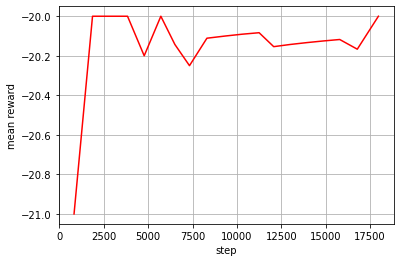

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(record_step, record_reward, color="red")
plt.grid()
plt.xlabel("step")
plt.ylabel("mean reward")
plt.savefig("./dqn_step_per_reward.png")
plt.show()
plt.clf()
plt.close()

グラフのダウンロード

In [ ]:
from google.colab import files
files.download("./dqn_step_per_reward.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 評価
学習したネットワーク（エージェント）を確認してみます．

ここでは，`frames`に描画したフレームを順次格納します．

In [ ]:
# 結果を描画するための設定
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display._obj._screen)


frames = []
for i in range(3):
    state = env.reset()
    done = False
    t = 0
    
    while not done and t < 200:
        frames.append(env.render(mode='rgb_array'))
        state_a = np.array([state], copy=False)
        state_v = torch.tensor(state_a)
        if use_cuda:
          state_v = state_v.cuda()
        q_vals_v = net(state_v)
        _, act_v = torch.max(q_vals_v, dim=1)
        action = int(act_v.item())
        new_state, reward, is_done, _ = env.step(action)
        state = new_state
        done = is_done
        t += 1

## 描画

maptlotlibを用いて，保存した動画フレームをアニメーションとして作成し，表示しています．

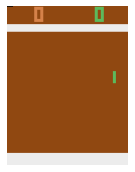

In [ ]:
# 実行結果の表示
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

# 課題

1. Experience replayやTarget Q-networkの有無による学習効率の違いを見てみましょう．
 * `use_experience_replay`，`use_target_q_network`によって使用するか指定可能です．
 * Pongは，デフォルトの報酬設計が-1，0，1のため，Clipping Rewardの有無による違いを確認する必要がありません．